# Importing modules

In [1]:
import re
import csv
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras import callbacks
from keras.preprocessing import sequence
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils

In [2]:
# fix random seed for reproducibility
np.random.seed(7)

# ## Loading Data

In [3]:
phrase = []
labels = []
test_phrase = []

d1={"positive" : 2, "neutral":1,"negative":0}

# load training data
#with open("project_train.csv", encoding="utf8") as fd:
rd = pd.read_csv("D:\RankingColleges\project_train.csv")
df = pd.DataFrame(rd,columns=['phrase', 'label'])
df = df.dropna()
phrase = df["phrase"]
labels = df["label"]
labels=labels.map(d1)

df["phrase"] = phrase
df["label"] = labels





In [4]:
df

,phrase,label
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica plus you've added commercials t...,2
2,@VirginAmerica I didn't today... Must mean I n...,1
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0
...,...,...
14635,@AmericanAir thank you we got on a different f...,2
14636,@AmericanAir leaving over 20 minutes Late Flig...,0
14637,@AmericanAir Please bring American Airlines to...,1
14638,"@AmericanAir you have my money, you change my ...",0


In [5]:
df.head()

,phrase,label
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica plus you've added commercials t...,2
2,@VirginAmerica I didn't today... Must mean I n...,1
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0


In [6]:
test_phrase = []

In [7]:
test_clean_phrases = []
for xw in test_phrase:
    new_test = clean_phrase(xw)
    test_clean_phrases.append(new_test)

# Data Preprocessing

In [8]:
# function to preprocess the sentences of the reviews.
def clean_phrase(phrase):
    #Remove punctuation (with a regular expression) and convert to lower case
    words = (re.sub("[^a-zA-Z]", " ", str(phrase))).lower()
    return words

In [9]:
# remove the first row of the train dataset which is currently the header
del phrase[0]

In [10]:
# run preprocessing function on train dataset
clean_phrases = []
for x in phrase:
    new = clean_phrase(x)
    clean_phrases.append(new)

In [11]:
# run preprocessing function  on test dataset
test_clean_phrases = []
for xw in test_phrase:
    new_test = clean_phrase(xw)
    test_clean_phrases.append(new_test)

# join the rows as a string with '/n' as delimiter
all_text=' /n '.join(clean_phrases)
test_all_text=' /n '.join(test_clean_phrases)

In [12]:
# split each reviews of the training dataset and join them as a string
reviews = all_text.split(' /n ')
all_text = ' '.join(reviews)

In [13]:
# split each word of the training dataset in the string to a list
words = all_text.split()


In [14]:

# join the rows as a string with '/n' as delimiter
all_text=' /n '.join(clean_phrases)
test_all_text=' /n '.join(test_clean_phrases)

In [15]:
# split each reviews of the training dataset and join them as a string
test_reviews = test_all_text.split(' /n ')
test_all_text = ' '.join(test_reviews)
# split each word of the training dataset in the string to a list
test_words = test_all_text.split()

In [16]:
# print no of rows for train and test 
print("Train reviews: {}".format(len(reviews)))
print("Test reviews: {}".format(len(test_reviews)))

Train reviews: 14639
Test reviews: 1


In [17]:
# remove the first row of the labels which is currently the header
del labels[0]

In [18]:
# preprocessing on the label list
labels_cleaned = '\n'.join([str(i) for i in labels])
labels_cleaned_last = labels_cleaned.split('\n')

In [19]:
# convert list to an array

labels_sentiment = [int(i) for i in labels_cleaned_last]
labels = np.array(labels_sentiment)




In [20]:

# combine the list that contains the individual words in the datasets
full_words = words + test_words

In [21]:
#create dictionaries that map the words in the vocabulary to integers. 
#Then we can convert each of our reviews into integers so they can be passed into the network.
from collections import Counter
counts = Counter(full_words)
vocab = sorted(counts, key=counts.get, reverse=True)


In [22]:

#Build a dictionary that maps words to integers
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

In [23]:
#Encode the words with integers. 
reviews_ints = []
for each in reviews:
    reviews_ints.append([vocab_to_int[word] for word in each.split( )])
    
test_reviews_ints = []
for eachs in test_reviews:
    test_reviews_ints.append([vocab_to_int[word] for word in eachs.split( )])


In [24]:
# check no of unique words in the corpus
# this will be the features to be extracted
print("No. of Features to be extracted: {}".format(len(vocab_to_int)))


No. of Features to be extracted: 13660


In [25]:
review_lens = Counter([len(x) for x in reviews_ints])
print("Zero-length reviews: {}".format(review_lens[0]))
print("Maximum tweet length: {}".format(max(review_lens)))


Zero-length reviews: 0
Maximum tweet length: 34


In [26]:
# check total no of rows not having zero length reviews
non_zero_idx = [ii for ii, review in enumerate(reviews_ints) if len(review) != 0]


In [27]:
# remove zero length reviews
reviews_ints = [reviews_ints[ii] for ii in non_zero_idx]
labels = np.array([labels[ii] for ii in non_zero_idx])


In [28]:
#check again
review_lens = Counter([len(x) for x in reviews_ints])
print("Zero-length reviews: {}".format(review_lens[0]))
print("Maximum review length: {}".format(max(review_lens)))

Zero-length reviews: 0
Maximum review length: 34


In [29]:
#As maximum review length too many steps for CNN. Let's truncate to 12 steps. 
#For reviews shorter than 12 steps, we'll pad with 0s. For reviews longer than 12 steps,
# we will truncate them to the first 12 characters.
max_review_length = 12
X_train = sequence.pad_sequences(reviews_ints, maxlen=max_review_length)
x_test = sequence.pad_sequences(test_reviews_ints, maxlen=max_review_length)

In [30]:
print(X_train.shape)

(14639, 12)


In [31]:
print(x_test.shape)

(1, 12)


In [32]:
# check no of unique words in the corpus
# Adding 1 because we use 0's for padding, dictionary started at 1
# this value will be passed to the embedding layer
top_words = len(vocab_to_int) + 1
print(top_words)

13661


In [33]:
# One Hot Encoding the labels
y_train = np_utils.to_categorical(labels, 4)

# Exploratory Data Analysis

In [34]:
df.columns

Index(['phrase', 'label'], dtype='object')

In [35]:
df.shape

(14640, 2)

In [36]:
df.isna().any()

phrase    False
label     False
dtype: bool

In [37]:
df.isnull().count()

phrase    14640
label     14640
dtype: int64

In [38]:
df.describe

<bound method NDFrame.describe of                                                   phrase  label
0                    @VirginAmerica What @dhepburn said.      1
1      @VirginAmerica plus you've added commercials t...      2
2      @VirginAmerica I didn't today... Must mean I n...      1
3      @VirginAmerica it's really aggressive to blast...      0
4      @VirginAmerica and it's a really big bad thing...      0
...                                                  ...    ...
14635  @AmericanAir thank you we got on a different f...      2
14636  @AmericanAir leaving over 20 minutes Late Flig...      0
14637  @AmericanAir Please bring American Airlines to...      1
14638  @AmericanAir you have my money, you change my ...      0
14639  @AmericanAir we have 8 ppl so we need 2 know h...      1

[14640 rows x 2 columns]>

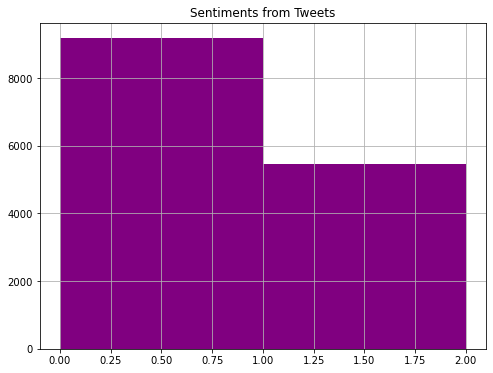

In [39]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
df.hist(bins=[0,1,2],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets")
plt.show()

In [40]:

pos = df["phrase"][df["label"] == 2]

neu = df["phrase"][df["label"] == 1]

neg = df["phrase"][df["label"] == 0]

In [41]:
print("Positive Count : " + str(pos.size))
print("Negative Count : " + str(neg.size))
print("Neutral Count : " + str(neu.size))


Positive Count : 2363
Negative Count : 9178
Neutral Count : 3099


# Training

In [42]:
# Creating Callbacks which is used in the Keras fit function
# ModelCheckpoints is used to save the model after every epoch
# EarlyStopping is used to stop training when the validation loss has not improved after 2 epochs
# Tensorboard is used tovisualize dynamic graphs of the training and test metrics

In [43]:
cbks = [callbacks.ModelCheckpoint(filepath='./checkpoint_model.h5', monitor='val_accuracy', save_best_only=True),
            callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)]


# Final Model Architecture built using Keras


In [44]:
# embedding layer size
embedding_vecor_length = 32

model = Sequential()
model.add(Embedding(19479, embedding_vecor_length, input_length=max_review_length)) #, dropout=0.2
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
# 1 layer of 100 units in the hidden layers of the LSTM cells
model.add(LSTM(100))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mse', 'mae', 'mape'])
print(model.summary())
hist = model.fit(X_train, y_train,validation_split=0.20, epochs=5,verbose=1, batch_size=32, callbacks = cbks)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 12, 32)            623328    
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 6, 32)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 4)                 404       
Total params: 680,036
Trainable params: 680,036
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
366/366 [==============================] - 21s 23ms/step - loss: 0.9114 - accuracy: 0.6316 - mse: 0.1

In [45]:
model = load_model('checkpoint_model.h5')

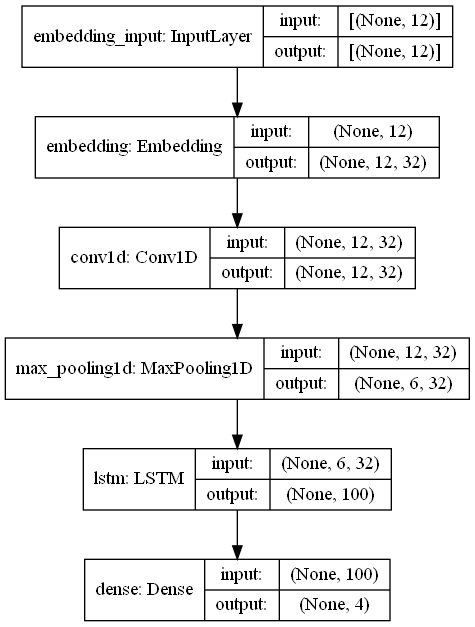

In [46]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Model Training History

In [47]:
print(hist.history.keys())


dict_keys(['loss', 'accuracy', 'mse', 'mae', 'mape', 'val_loss', 'val_accuracy', 'val_mse', 'val_mae', 'val_mape'])


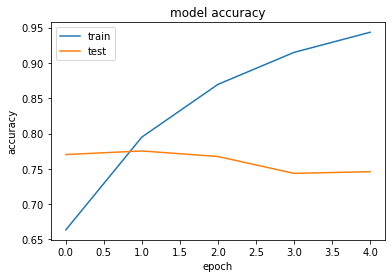

In [48]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()


In [49]:
print("------------------------------")
print("           Train   |   Test")
print("Accuracy : ",round(max(hist.history['accuracy'])*100,2)," | ",round(max(hist.history['val_accuracy']),2)*100)
print("Loss  :     ",round(max(hist.history['loss']),2)," | ",round(max(hist.history['val_loss']),2))
print("------------------------------")


------------------------------
           Train   |   Test
Accuracy :  94.35  |  78.0
Loss  :      0.79  |  0.87
------------------------------


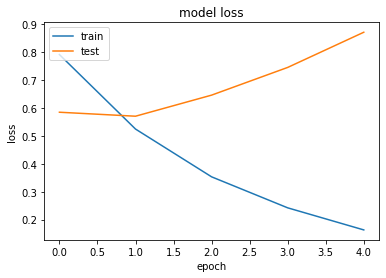

In [50]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

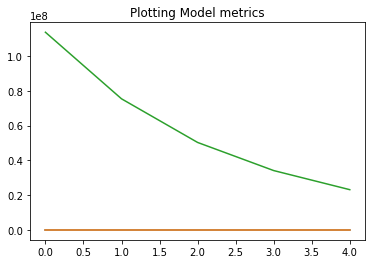

In [51]:
from matplotlib import pyplot
plt.title('Plotting Model metrics')
pyplot.plot(hist.history['mse'])
pyplot.plot(hist.history['mae'])
pyplot.plot(hist.history['mape'])
pyplot.show()

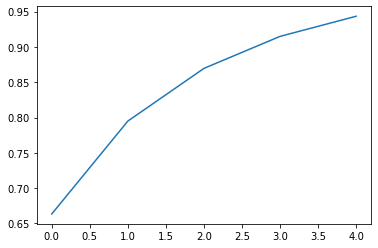

In [52]:
pyplot.plot(hist.history['accuracy'])

# Saving the model

In [53]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\python38\python.exe -m pip install --upgrade pip' command.


In [54]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [55]:

'''
Code to Load Saved Model
'''

from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [56]:
loaded_model